In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from itertools import islice
import os

In [2]:
df = pd.read_csv("data_csv/by_country/total.csv")
countries = list(pd.read_csv("data_csv/by_country/total.csv").set_index("Nation").index.unique())
input = iter(countries)
slices = [100, 100, 100]
output = [list(islice(input, e)) for e in slices]

In [3]:
def total_confirmed_global():
    global df
    df_time = df.copy()
    df_time["Time"] = pd.to_datetime(df_time["Time"])
    gb = df_time.groupby("Time")
    t = []
    c = []
    d = []
    r = []
    for i, frame in gb:
        t.append(i.strftime("%b-%d"))
        c.append(np.sum(frame["Confirmed Case"]))
        d.append(np.sum(frame["Death"]))
        r.append(np.sum(frame["Recover"]))
    df_total = pd.DataFrame({"Time":t, "Confirmed Case":c, "Death":d, "Recover":r})
    df_total["Active"] = df_total["Confirmed Case"]-df_total["Death"]-df_total["Recover"]
    fig = plt.figure()
    plt.plot(df_total["Time"], df_total["Confirmed Case"], linewidth=5, c='r')
    plt.plot(df_total["Time"], df_total["Death"], linewidth=5, c='#4A4A4A')
    plt.plot(df_total["Time"], df_total["Recover"], linewidth=5, c='#3ad800')
    plt.plot(df_total["Time"], df_total["Active"], linewidth=5, c='#5d5dff')
    plt.xlabel("Time", fontsize=18)
    plt.ylabel("Number of Cases", fontsize=18)
    plt.title("Global Cumulative Cases", fontsize=18)
    plt.tight_layout()
    fig.set_figheight(9)
    fig.set_figwidth(12)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))
    plt.gca().tick_params(axis="x", labelsize=18)
    plt.gca().tick_params(axis="y", labelsize=18)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xticks(rotation=45)
    plt.grid(b=1, which="major", axis="both", c='#C0C0C0')
    plt.legend()
    plt.savefig("results/total.png")
    plt.close(fig)
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(12)
    confirmed = df_total.iloc[-1]["Confirmed Case"]
    recover = 100*df_total.iloc[-1]["Recover"]/confirmed
    death = 100*df_total.iloc[-1]["Death"]/confirmed
    active = 100*df_total.iloc[-1]["Active"]/confirmed
    x = ["Recovery\Rate", "Mortality\nRate", "Active"]
    y = [recover, death, active]
    bars = plt.barh(x, y)
    bars[0].set_color("#5dff5d")
    bars[1].set_color("#aaaaaa")
    bars[2].set_color("#5d5dff")
    plt.gca().tick_params(axis="y", labelsize=18)
    plt.xlim(0,100)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
    for i, v in enumerate(y):
        plt.text(v+2, i, str(round(v, 2))+"%", fontsize=18)
    plt.tight_layout()
    plt.savefig("results/distribution.png")
    
#     return df_total.iloc[-1]["Confirmed Case"]

In [4]:
def cases_plot(df):
    fig = plt.figure()
    df["Active"] = df["Confirmed Case"]-df["Death"]-df["Recover"]
    plt.plot(pd.to_datetime(df["Time"]).dt.strftime("%b-%d"),df["Confirmed Case"], linewidth=5, c='r')
    plt.plot(pd.to_datetime(df["Time"]).dt.strftime("%b-%d"),df["Death"], linewidth=5, c='#4A4A4A')
    plt.plot(pd.to_datetime(df["Time"]).dt.strftime("%b-%d"),df["Recover"], linewidth=5, c='#3ad800')
    plt.plot(pd.to_datetime(df["Time"]).dt.strftime("%b-%d"),df["Active"], linewidth=5, c='#5d5dff')
    plt.xlabel("Time", fontsize=18)
    plt.ylabel("Number of Cases", fontsize=18)
    plt.title("{} Coronavirus Count".format(country), fontsize=18)
    plt.tight_layout()
    fig.set_figheight(9)
    fig.set_figwidth(12)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))
    plt.gca().tick_params(axis="x", labelsize=18)
    plt.gca().tick_params(axis="y", labelsize=18)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xticks(rotation=45)
    plt.grid(b=1, which="major", axis="both", c='#C0C0C0')
    plt.legend()
    plt.savefig("results/confirmed_cases_country/confirmed_cases_{}.png".format(country))
    plt.close(fig)

In [5]:
def get_daily():
    global df
    df_a = df.copy()
    timeline = []
    time_init = pd.to_datetime("04/03/2020 09:00:01")
    df_a["Time"] = pd.to_datetime(df_a["Time"])
    time_end = df_a.sort_values("Time").iloc[-1]["Time"]
    
    while time_init<time_end:
        timeline.append(time_init)
        time_init+=pd.Timedelta("1 days")
        
    return timeline

In [6]:
def daily_plot(df):
    df = df.set_index("Nation")
    df["Time"] = pd.to_datetime(df["Time"])
    timeline = get_daily()
    date = []
    confirmed, death, recover = [], [], []
    for i in range(len(timeline)-1):
        df_daily = df.copy()
        t1 = timeline[i]
        t2 = timeline[i+1]
        df_daily = df_daily[df_daily["Time"]>t1]
        df_daily = df_daily[df_daily["Time"]<t2]
        df_daily = df_daily[df_daily["Time"]==np.max(df_daily["Time"])]
        if df_daily.empty:
            confirmed.append(0)
            death.append(0)
            recover.append(0)
            date.append(t1)
        else:
            confirmed.append(df_daily["Confirmed Case"][0])
            death.append(df_daily["Death"][0])
            recover.append(df_daily["Recover"][0])
            date.append(df_daily["Time"][0])
    
    confirmed = [confirmed[i+1]-confirmed[i] for i in range(len(confirmed)-1)]
    death = [death[i+1]-death[i] for i in range(len(death)-1)]
    recover = [recover[i+1]-recover[i] for i in range(len(recover)-1)]
    date.remove(date[0])
    df_daily = pd.DataFrame({"Date":date, "Confirmed Case":confirmed, "Death":death, "Recover":recover})
    df_daily["Date"] = pd.Series([(t.round(freq="D")) for t in df_daily["Date"]])
    fig = plt.figure()
    length = int(len(df_daily)/7)
    for i in range(length):
        if os.path.isfile("results/daily_cases_country/daily_cases_{}_week{}.png".format(country, i+1)):
            pass
        else:
            fig = plt.figure()
            x = date2num(list(df_daily['Date'].iloc[7*(i):7*(i+1)]))
            plt.bar(x, list(df_daily["Confirmed Case"].iloc[7*(i):7*(i+1)]), color='red', align="center", width=0.3, label="Confirmed")
            plt.bar(x+0.3, list(df_daily["Death"].iloc[7*(i):7*(i+1)]), color='#4A4A4A', align="center", width=0.3, label = "Death")
            plt.bar(x-0.3, list(df_daily["Recover"].iloc[7*(i):7*(i+1)]), color='#3ad800', align="center", width=0.3, label = "Recover")
            plt.gca().xaxis_date()
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
            fig.set_figheight(9)
            fig.set_figwidth(12)
            plt.xlabel("Date", fontsize=18)
            plt.ylabel("Number of cases", fontsize=18)
            plt.title("Weekly Cases in {}".format(country), fontsize=18)
            plt.gca().tick_params(axis="x", labelsize=18)
            plt.gca().tick_params(axis="y", labelsize=18)
            plt.gca().spines["top"].set_visible(False)
            plt.gca().spines["right"].set_visible(False)
            plt.grid(b=1, which="major", axis="y", c='#C0C0C0')
            plt.xticks(rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.savefig("results/daily_cases_country/daily_cases_{}_week{}.png".format(country, i+1))
            plt.close(fig)
#     return df_daily

In [7]:
def top10_confirmed():
    global df
    df_top = df.copy()
    df_top["Time"] = pd.to_datetime(df_top["Time"])
    df_top = df_top[df_top["Time"]==np.max(df_top["Time"])]
    df_top = df_top.sort_values("Confirmed Case", ascending=False)
    fig = plt.figure()
    fig.set_figheight(9)
    fig.set_figwidth(12)
    plt.barh(df_top.head(10)["Nation"], df_top.head(10)["Confirmed Case"], color="#724ddf")
    plt.gca().tick_params(axis="x", labelsize=18)
    plt.gca().tick_params(axis="y", labelsize=18)
    plt.xticks(rotation=30)
    plt.gca().invert_yaxis()
    plt.xlabel("Number of cases", fontsize=18)
    plt.ylabel("Country", fontsize=18)
    plt.title("Global Top 10", fontsize=18)
    plt.grid(b=1, which="major", axis="x", c='#C0C0C0')
    for i, v in enumerate(df_top.head(10)["Confirmed Case"]):
        plt.text(v + 3, i + .25, str(v), color='#724ddf', fontweight='bold', fontsize=12)
    xmax = df_top.head(10)["Confirmed Case"].iloc[0] + 250000
    plt.gca().set_xlim([0,xmax])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("results/top10_global_confirmed.png")
#     return df_top.head(10)["Confirmed Case"].iloc[0]

In [8]:
def rates(df):
    df_l = df.copy()
    df_l["Time"] = pd.to_datetime(df_l["Time"])
    df_l = df_l[df_l["Time"]==np.max(df_l["Time"])]
    labels = ["Active", "Deaths", "Recovered"]
    df_l["Active"] = df_l["Confirmed Case"] - df_l["Death"] - df_l["Recover"]
    active = 100 * df_l["Active"].values[0]/df_l["Confirmed Case"].values[0]
    death = 100 * df_l["Death"].values[0]/df_l["Confirmed Case"].values[0]
    recover = 100 * df_l["Recover"].values[0]/df_l["Confirmed Case"].values[0]
    x = ["Recovery\nRate", "Mortality\nRate", "Active"]
    y = [recover, death, active]
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(12)
    if df_l["Confirmed Case"].values[0]!=0:
        bars = plt.barh(x, y)
        bars[0].set_color("#5dff5d")
        bars[1].set_color("#aaaaaa")
        bars[2].set_color("#5d5dff")
    else:
        bar = plt.barh(["No Data Available/\nNo Recorded Case"], [0.0])
    plt.gca().tick_params(axis="y", labelsize=18)
    plt.xlim(0,100)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
    for i, v in enumerate(y):
        plt.text(v+2, i, str(round(v, 2))+"%", fontsize=18)
    plt.tight_layout()
    plt.savefig("results/percent/{}.png".format(country))
    plt.close(fig)
#     return x,y

In [9]:
for country in countries:
# for country in output[0]:
# for country in output[1]:
# for country in output[2]:
    df_x = pd.read_csv("data_csv/by_country/{}.csv".format(country))
    print(country)
    cases_plot(df_x)
#     daily_plot(df_x)
    rates(df_x)

AFGHANISTAN
ALBANIA
ALGERIA
ANDORRA
ANGOLA
ANGUILLA
ANTIGUA AND BARBUDA
ARGENTINA
ARMENIA
ARUBA
AUSTRALIA
AUSTRIA
AZERBAIJAN
BAHAMAS
BAHRAIN
BANGLADESH
BARBADOS
BELARUS
BELGIUM
BELIZE
BENIN
BERMUDA
BHUTAN
BOLIVIA
BOSNIA-HERZEGOVINA
BOTSWANA
BRAZIL
BRITISH VIRGIN ISLANDS
BRUNEI
BULGARIA
BURKINA FASO
BURUNDI
CABO VERDE
CAMBODIA
CAMEROON
CANADA
CAYMAN ISLAND
CENTRAL AFRICAN REPUBLIC
CHAD
CHANNEL ISLANDS
CHILE
CHINA, Mainland
COLOMBIA
COMOROS
CONGO
COSTA RICA
COTE D'IVOIRE
CROATIA
CUBA
CURACAO
CYPRUS
CZECH REPUBLIC
DENMARK
DJIBOUTI
DOMINICA
DOMINICAN REPUBLIC
DPR KOREA


/home/chetanborse1999/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/home/chetanborse1999/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/chetanborse1999/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


DR CONGO
ECUADOR
EGYPT
EL SALVADOR
EQUATORIAL GUINEA
ERITREA
ESTONIA
ESWATINI
ETHIOPIA
FAEROE ISLANDS
FALKLAND ISLANDS
FIJI
FINLAND
FRANCE
FRENCH GUIANA
FRENCH POLYNESIA
GABON
GAMBIA
GEORGIA
GERMANY
GHANA
GIBRALTAR
GREECE
GREENLAND
GRENADA
GUADELOUPE
GUAM
GUATEMALA
GUINEA
GUINEA-BISSAU
GUYANA
HAITI
HONDURAS
HONG KONG
HUNGARY
ICELAND
INDIA
INDONESIA
IRAN
IRAQ
IRELAND
ISLE OF MAN
ISRAEL
ITALY
JAMAICA
JAPAN
JORDAN
KAZAKHSTAN
KENYA
KIRIBATI


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


KOSOVO
KUWAIT
KYRGYZSTAN
LAOS
LATVIA
LEBANON
LESOTHO
LIBERIA
LIBYA
LIECHTENSTEIN
LITHUANIA
LUXEMBOURG
MACAU
MADAGASCAR
MALAWI
MALAYSIA
MALDIVES
MALI
MALTA
MARTINIQUE
MAURITANIA
MAURITIUS
MAYOTTE
MEXICO
MICRONESIA (FED. STATES OF)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


MOLDOVA
MONACO
MONGOLIA
MONTENEGRO
MONTSERRAT
MOROCCO
MOZAMBIQUE
MYANMAR
N. MACEDONIA
NAMIBIA
NEPAL
NETHERLANDS
NEW CALEDONIA
NEW ZEALAND
NICARAGUA
NIGER
NIGERIA
NORTHERN MARIANA ISLANDS
NORWAY
OMAN
OTHER
PAKISTAN
PALESTINE
PANAMA
PAPUA NEW GUINEA
PARAGUAY
PERU
PHILIPPINES
POLAND
PORTUGAL
PUERTO RICO
QATAR
REUNION
ROMANIA
RUSSIA
RWANDA
S. AFRICA
S. KOREA
S. SUDAN
SAINT BARTHELEMY
SAINT LUCIA
SAINT MARTIN
SAINT VINCENT
SAMOA


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


SAN MARINO
SAO TOME AND PRINCIPE
SAUDI ARABIA
SENEGAL
SERBIA
SEYCHELLES
SIERRA LEONE
SINGAPORE
SINT MAARTEN
SLOVAKIA
SLOVENIA
SOLOMON ISLANDS
SOMALIA
SPAIN
SRI LANKA
ST.KITTS AND NEVIS
SUDAN
SURINAME
SWEDEN
SWITZERLAND
SYRIA
SYRIAN ARAB REPUBLIC
TAIWAN
TAJIKISTAN
TANZANIA
THAILAND
TIMOR-LESTE
TOGO
TONGA


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


TRINIDAD AND TOBAGO
TUNISIA
TURKEY
TURKMENISTAN


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


TURKS AND CAICOS
UAE
UGANDA
UKRAINE
UNITED KINGDOM
UNITED STATES
URUGUAY
US VIRGIN ISLANDS
UZBEKISTAN
VANUATU


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


VATICAN CITY
VENEZUELA
VIETNAM
WESTERN SAHARA
YEMEN
ZAMBIA
ZIMBABWE
noname18


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


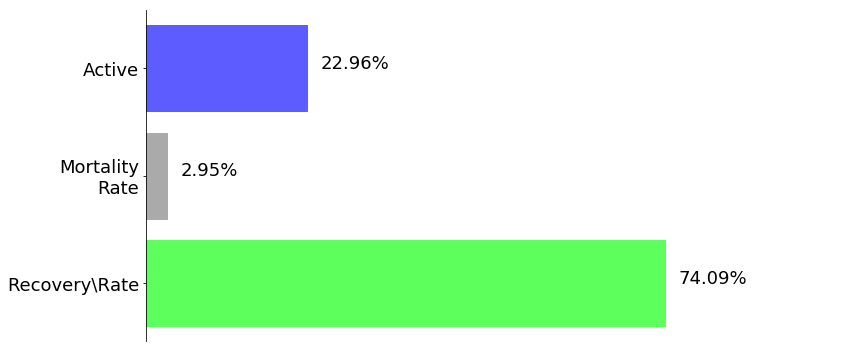

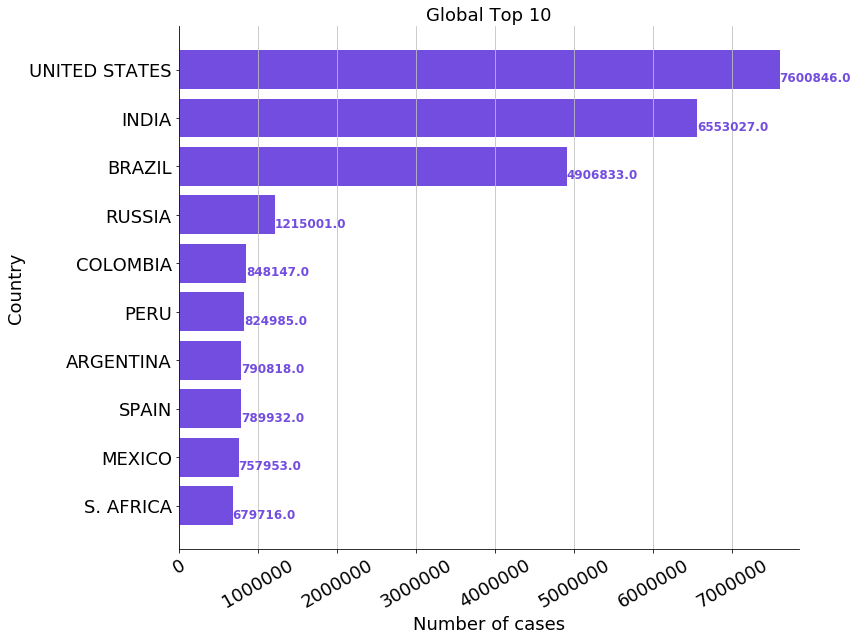

In [10]:
total_confirmed_global()
top10_confirmed()

In [11]:
output

[['AFGHANISTAN',
  'ALBANIA',
  'ALGERIA',
  'ANDORRA',
  'ANGOLA',
  'ANGUILLA',
  'ANTIGUA AND BARBUDA',
  'ARGENTINA',
  'ARMENIA',
  'ARUBA',
  'AUSTRALIA',
  'AUSTRIA',
  'AZERBAIJAN',
  'BAHAMAS',
  'BAHRAIN',
  'BANGLADESH',
  'BARBADOS',
  'BELARUS',
  'BELGIUM',
  'BELIZE',
  'BENIN',
  'BERMUDA',
  'BHUTAN',
  'BOLIVIA',
  'BOSNIA-HERZEGOVINA',
  'BOTSWANA',
  'BRAZIL',
  'BRITISH VIRGIN ISLANDS',
  'BRUNEI',
  'BULGARIA',
  'BURKINA FASO',
  'BURUNDI',
  'CABO VERDE',
  'CAMBODIA',
  'CAMEROON',
  'CANADA',
  'CAYMAN ISLAND',
  'CENTRAL AFRICAN REPUBLIC',
  'CHAD',
  'CHANNEL ISLANDS',
  'CHILE',
  'CHINA, Mainland',
  'COLOMBIA',
  'COMOROS',
  'CONGO',
  'COSTA RICA',
  "COTE D'IVOIRE",
  'CROATIA',
  'CUBA',
  'CURACAO',
  'CYPRUS',
  'CZECH REPUBLIC',
  'DENMARK',
  'DJIBOUTI',
  'DOMINICA',
  'DOMINICAN REPUBLIC',
  'DPR KOREA',
  'DR CONGO',
  'ECUADOR',
  'EGYPT',
  'EL SALVADOR',
  'EQUATORIAL GUINEA',
  'ERITREA',
  'ESTONIA',
  'ESWATINI',
  'ETHIOPIA',
  'FAEROE I